# New York Green taxi trip records analysis

***Please notice that our dataset is large and if you get memory error, please resart the notebook and run the queries before part 3: analysis, then continue the following analysis.***

In [2]:
import os
os.environ['SPARK_HOME'] = '/usr/local/lib/spark'
import findspark
findspark.init()
from pyspark import SparkContext
spark = SparkContext("local", appName='project-04')
spark

<SparkContext master=local appName=project-04>

In [1]:
!wget https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2017-06.csv

--2017-12-07 23:32:11--  https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2017-06.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.164.101
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.164.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87477546 (83M) [application/x-www-form-urlencoded]
Saving to: ‘green_tripdata_2017-06.csv’

green_tripdata_2017 100%[===================>]  83.42M  59.0MB/s    in 1.4s    

2017-12-07 23:32:13 (59.0 MB/s) - ‘green_tripdata_2017-06.csv’ saved [87477546/87477546]



In [3]:
from pyspark import SQLContext
sqlc = SQLContext(spark)
sqlc

In [4]:
#Increase the executor and driver memory to avoid out of memory error
SparkContext.setSystemProperty('spark.executor.memory', '8g')
SparkContext.setSystemProperty('spark.driver.memory', '8g')

## Part 1: Slection

*** Select Data and import the data***

We selected the NYC green taxi trip records as our research object.

The green taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.
The data collected and provided to the NYC Taxi and technology providers.  We downloaded the raw data from the link (http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml).

New York City is one of the largest cities in the United States and traffic issues are always haunting NYC. We want to probe the taxi data to dig out some patterns of NYC transportation and traits of taxi transaction.

In [6]:
green = sqlc.read.format("csv").option("header", "true").load("green_tripdata_2017-06.csv")
green.count()

976467

In [7]:
green.take(3)

[Row(VendorID='2', lpep_pickup_datetime='2017-06-01 00:33:45', lpep_dropoff_datetime='2017-06-01 01:39:52', store_and_fwd_flag='N', RatecodeID='4', PULocationID='35', DOLocationID='265', passenger_count='1', trip_distance='90.41', fare_amount='404.5', extra='0.5', mta_tax='0.5', tip_amount='0', tolls_amount='5.76', ehail_fee=None, improvement_surcharge='0.3', total_amount='413.51', payment_type='2', trip_type='1'),
 Row(VendorID='2', lpep_pickup_datetime='2017-06-01 00:33:55', lpep_dropoff_datetime='2017-06-01 23:36:23', store_and_fwd_flag='N', RatecodeID='1', PULocationID='263', DOLocationID='75', passenger_count='1', trip_distance='.38', fare_amount='4', extra='0.5', mta_tax='0.5', tip_amount='1.59', tolls_amount='0', ehail_fee=None, improvement_surcharge='0.3', total_amount='6.89', payment_type='1', trip_type='1'),
 Row(VendorID='2', lpep_pickup_datetime='2017-06-01 00:12:07', lpep_dropoff_datetime='2017-06-01 00:12:07', store_and_fwd_flag='N', RatecodeID='1', PULocationID='255', DO

*** Look at the summary statistics ***

We used ‘csv stat’ and ‘xsv’ to do an initial data exploration. We determine our theme is about the common routes and factors to taxi transaction.

In [8]:
import pandas as pd
green_jun = pd.read_csv("green_tripdata_2017-06.csv")
green_jun.sample(n=10000).to_csv('sample.csv', index = False)

In [9]:
!csvstat sample.csv

  1. VendorID
	<class 'int'>
	Nulls: False
	Values: 1, 2
  2. lpep_pickup_datetime
	<class 'datetime.datetime'>
	Nulls: False
	Min: 2017-06-01 00:03:23
	Max: 2017-06-30 23:57:30
	Unique values: 9976
	5 most frequent values:
		2017-06-27 08:57:06:	2
		2017-06-03 13:07:15:	2
		2017-06-14 14:24:26:	2
		2017-06-09 11:26:38:	2
		2017-06-23 12:45:00:	2
  3. lpep_dropoff_datetime
	<class 'datetime.datetime'>
	Nulls: False
	Min: 2017-06-01 00:15:47
	Max: 2017-07-01 21:19:50
	Unique values: 9967
	5 most frequent values:
		2017-06-08 17:25:45:	2
		2017-06-18 17:46:36:	2
		2017-06-10 01:04:31:	2
		2017-06-16 00:00:00:	2
		2017-06-07 21:44:19:	2
  4. store_and_fwd_flag
	<class 'bool'>
	Nulls: False
	Unique values: 2
	5 most frequent values:
		False:	9989
		True:	11
  5. RatecodeID
	<class 'int'>
	Nulls: False
	Values: 1, 2, 3, 4, 5
  6. PULocationID
	<class 'int'>
	Nulls: False
	Min: 3
	Max: 265
	Sum: 1127022
	Mean: 112.7022
	Median: 82.0
	Standard Deviation: 75.87679431262333
	Unique values: 162


In [11]:
!xsv stats green_tripdata_2017-06.csv

field,type,sum,min,max,min_length,max_length,mean,stddev
VendorID,Integer,1752997,1,2,1,1,1.795244488548983,0.40352285187014103
lpep_pickup_datetime,Unicode,,2017-06-01 00:00:00,2017-06-30 23:59:59,19,19,,
lpep_dropoff_datetime,Unicode,,2017-06-01 00:00:00,2017-07-01 23:45:11,19,19,,
store_and_fwd_flag,Unicode,,N,Y,1,1,,
RatecodeID,Integer,1053122,1,99,1,2,1.0785023969064425,0.5534378026299072
PULocationID,Integer,109276225,1,265,1,3,111.90979828299086,75.97746463736003
DOLocationID,Integer,126354708,1,265,1,3,129.39987526460445,77.27918464243584
passenger_count,Integer,1323355,0,9,1,1,1.3552480524175532,1.0208071368285072
trip_distance,Float,2643000.339999917,0,170.59,3,6,2.706697041476892,2.842227781970804
fare_amount,Float,11699125.550000003,-350,637.5,1,6,11.981076216605082,9.466846250681103
extra,Float,348177.4000000003,-4.5,12,1,4,0.3565685271494018,0.39841839854684286
mta_tax,Float,476610.5,-0.5,0.5,1,4,0.4880968839704849,0.08272048623899603
tip_amount,Float,1180301.239999722,-2

*** Questions we want to answer ***

* Top 10 popular pick up & drop off locations
* The relationship of pick-up and drop-off locations - heat map
* Top 10 common route
* Distance & time hists
* Total amount histogram
* Check the relationship of speed and hours

*** Our concern ***

The data quality is a large issue for us. Some of data was provided manually so there are missing value and counter-intuitive data in the dataset. Return transactions also consist of  a part of data. We need to wrangling our data before we do further analysis.

## Part 2.Wrangling

#### According to the summary, we do some data wrangling:

#### First, we drop all the columns that are all missing values.

In [12]:
green = green.drop('ehail_fee', 'store_and_fwd_flag')

#### When the whole tables were imported into Spark, every columns were text data type. Then we changed the data types after importing the data.


In [13]:
datatype = ['integer','timestamp','timestamp','integer','integer','integer','integer','float','float','float','float','float',
            'float','float','float','integer','integer']

In [14]:
for i in range(len(green.schema.names)):
    green = green.withColumn(green.schema.names[i],green[green.schema.names[i]].cast(datatype[i]))

In [15]:
green.take(5)

[Row(VendorID=2, lpep_pickup_datetime=datetime.datetime(2017, 6, 1, 0, 33, 45), lpep_dropoff_datetime=datetime.datetime(2017, 6, 1, 1, 39, 52), RatecodeID=4, PULocationID=35, DOLocationID=265, passenger_count=1, trip_distance=90.41000366210938, fare_amount=404.5, extra=0.5, mta_tax=0.5, tip_amount=0.0, tolls_amount=5.760000228881836, improvement_surcharge=0.30000001192092896, total_amount=413.510009765625, payment_type=2, trip_type=1),
 Row(VendorID=2, lpep_pickup_datetime=datetime.datetime(2017, 6, 1, 0, 33, 55), lpep_dropoff_datetime=datetime.datetime(2017, 6, 1, 23, 36, 23), RatecodeID=1, PULocationID=263, DOLocationID=75, passenger_count=1, trip_distance=0.3799999952316284, fare_amount=4.0, extra=0.5, mta_tax=0.5, tip_amount=1.590000033378601, tolls_amount=0.0, improvement_surcharge=0.30000001192092896, total_amount=6.889999866485596, payment_type=1, trip_type=1),
 Row(VendorID=2, lpep_pickup_datetime=datetime.datetime(2017, 6, 1, 0, 12, 7), lpep_dropoff_datetime=datetime.datetime(

#### Since number of passengers are not possibly to be 0, we assigned ‘NA’ to 0 in ‘passenger_count’ column.

In [16]:
from pyspark.sql.functions import when
green = green.withColumn("passenger_count", \
              when(green["passenger_count"] == 0, 'NA').otherwise(green["passenger_count"]))

In [17]:
green.filter("passenger_count = 'NA'").take(5)

[Row(VendorID=2, lpep_pickup_datetime=datetime.datetime(2017, 6, 1, 1, 53, 1), lpep_dropoff_datetime=datetime.datetime(2017, 6, 1, 2, 19, 37), RatecodeID=5, PULocationID=74, DOLocationID=132, passenger_count='NA', trip_distance=17.350000381469727, fare_amount=52.0, extra=0.0, mta_tax=0.0, tip_amount=11.550000190734863, tolls_amount=5.760000228881836, improvement_surcharge=0.0, total_amount=69.30999755859375, payment_type=1, trip_type=2),
 Row(VendorID=2, lpep_pickup_datetime=datetime.datetime(2017, 6, 1, 8, 2, 2), lpep_dropoff_datetime=datetime.datetime(2017, 6, 1, 8, 11, 14), RatecodeID=5, PULocationID=130, DOLocationID=215, passenger_count='NA', trip_distance=1.7400000095367432, fare_amount=15.0, extra=0.0, mta_tax=0.0, tip_amount=0.0, tolls_amount=0.0, improvement_surcharge=0.0, total_amount=15.0, payment_type=2, trip_type=2),
 Row(VendorID=2, lpep_pickup_datetime=datetime.datetime(2017, 6, 1, 8, 57, 46), lpep_dropoff_datetime=datetime.datetime(2017, 6, 1, 9, 15, 11), RatecodeID=5, 

#### Create a new column named valid_data and assign default value of 1 - true, then define what is not valid data.

In [18]:
from pyspark.sql.functions import lit
green = green.withColumn("valid_data", lit(1))

In [19]:
green.take(5)

[Row(VendorID=2, lpep_pickup_datetime=datetime.datetime(2017, 6, 1, 0, 33, 45), lpep_dropoff_datetime=datetime.datetime(2017, 6, 1, 1, 39, 52), RatecodeID=4, PULocationID=35, DOLocationID=265, passenger_count='1', trip_distance=90.41000366210938, fare_amount=404.5, extra=0.5, mta_tax=0.5, tip_amount=0.0, tolls_amount=5.760000228881836, improvement_surcharge=0.30000001192092896, total_amount=413.510009765625, payment_type=2, trip_type=1, valid_data=1),
 Row(VendorID=2, lpep_pickup_datetime=datetime.datetime(2017, 6, 1, 0, 33, 55), lpep_dropoff_datetime=datetime.datetime(2017, 6, 1, 23, 36, 23), RatecodeID=1, PULocationID=263, DOLocationID=75, passenger_count='1', trip_distance=0.3799999952316284, fare_amount=4.0, extra=0.5, mta_tax=0.5, tip_amount=1.590000033378601, tolls_amount=0.0, improvement_surcharge=0.30000001192092896, total_amount=6.889999866485596, payment_type=1, trip_type=1, valid_data=1),
 Row(VendorID=2, lpep_pickup_datetime=datetime.datetime(2017, 6, 1, 0, 12, 7), lpep_dro

### Delete all the return transactions and corresponding positive-amount transactions.

In [20]:
green = green.orderBy(['lpep_pickup_datetime','lpep_dropoff_datetime'])

In [21]:
simul_count = green.groupBy(['lpep_pickup_datetime','lpep_dropoff_datetime']).count()

In [22]:
simul_count.take(1)

[Row(lpep_pickup_datetime=datetime.datetime(2017, 6, 1, 0, 0), lpep_dropoff_datetime=datetime.datetime(2017, 6, 1, 0, 0), count=3)]

In [23]:
amount_sum = green.groupBy(['lpep_pickup_datetime','lpep_dropoff_datetime']).sum('total_amount')

In [24]:
amount_sum.take(1)

[Row(lpep_pickup_datetime=datetime.datetime(2017, 6, 1, 0, 0), lpep_dropoff_datetime=datetime.datetime(2017, 6, 1, 0, 0), sum(total_amount)=63.46000003814697)]

In [25]:
green = green.join \
           (simul_count, (green.lpep_pickup_datetime == simul_count.lpep_pickup_datetime) \
            & (green.lpep_dropoff_datetime == simul_count.lpep_dropoff_datetime), 'left') \
           .drop(simul_count.lpep_pickup_datetime).drop(simul_count.lpep_dropoff_datetime)

In [26]:
green.take(2)

[Row(VendorID=2, RatecodeID=1, PULocationID=43, DOLocationID=142, passenger_count='1', trip_distance=2.440000057220459, fare_amount=12.0, extra=0.0, mta_tax=0.5, tip_amount=0.0, tolls_amount=0.0, improvement_surcharge=0.30000001192092896, total_amount=12.800000190734863, payment_type=2, trip_type=1, valid_data=1, lpep_pickup_datetime=datetime.datetime(2017, 6, 1, 0, 0), lpep_dropoff_datetime=datetime.datetime(2017, 6, 1, 0, 0), count=3),
 Row(VendorID=2, RatecodeID=1, PULocationID=66, DOLocationID=65, passenger_count='1', trip_distance=5.619999885559082, fare_amount=19.5, extra=0.0, mta_tax=0.5, tip_amount=0.0, tolls_amount=0.0, improvement_surcharge=0.30000001192092896, total_amount=20.299999237060547, payment_type=2, trip_type=1, valid_data=1, lpep_pickup_datetime=datetime.datetime(2017, 6, 1, 0, 0), lpep_dropoff_datetime=datetime.datetime(2017, 6, 1, 0, 0), count=3)]

In [27]:
green = green.join \
           (amount_sum, (green.lpep_pickup_datetime == amount_sum.lpep_pickup_datetime) \
            & (green.lpep_dropoff_datetime == amount_sum.lpep_dropoff_datetime), 'left')\
           .drop(amount_sum.lpep_pickup_datetime).drop(amount_sum.lpep_dropoff_datetime)

In [28]:
green.take(2)

[Row(VendorID=2, RatecodeID=1, PULocationID=43, DOLocationID=142, passenger_count='1', trip_distance=2.440000057220459, fare_amount=12.0, extra=0.0, mta_tax=0.5, tip_amount=0.0, tolls_amount=0.0, improvement_surcharge=0.30000001192092896, total_amount=12.800000190734863, payment_type=2, trip_type=1, valid_data=1, lpep_pickup_datetime=datetime.datetime(2017, 6, 1, 0, 0), lpep_dropoff_datetime=datetime.datetime(2017, 6, 1, 0, 0), count=3, sum(total_amount)=63.46000003814697),
 Row(VendorID=2, RatecodeID=1, PULocationID=66, DOLocationID=65, passenger_count='1', trip_distance=5.619999885559082, fare_amount=19.5, extra=0.0, mta_tax=0.5, tip_amount=0.0, tolls_amount=0.0, improvement_surcharge=0.30000001192092896, total_amount=20.299999237060547, payment_type=2, trip_type=1, valid_data=1, lpep_pickup_datetime=datetime.datetime(2017, 6, 1, 0, 0), lpep_dropoff_datetime=datetime.datetime(2017, 6, 1, 0, 0), count=3, sum(total_amount)=63.46000003814697)]

#### When extra is not equal to 0, 0.5 or 1 or trip_distance is 0, change valid_data to 0.

In [29]:
green = green.withColumn("valid_data", \
              when((green["extra"] != 0) & (green["extra"] != 0.5) & (green["extra"] != 1) \
             | (green["trip_distance"] == 0) \
             | (green["lpep_pickup_datetime"] == green["lpep_dropoff_datetime"])
             | ((green["count"] == 2) & (green["sum(total_amount)"] == 0)), 0) \
             .otherwise(green["valid_data"]))

#### Verify that valid data is correct.

In [30]:
green.filter('(trip_distance = 0 \
              or extra not in (0, 0.5, 1) \
              or (count = 2 and total_amount = 0) \
              or lpep_pickup_datetime = lpep_dropoff_datetime)\
              and valid_data = 1').take(1)

[]

There is not value, meaning that our wrangling is correct.

## Part 3: Analysis

Spark -> SQL

In [31]:
green.createOrReplaceTempView("green")

In [32]:
sqlc.sql("""
    SELECT lpep_pickup_datetime, lpep_dropoff_datetime, valid_data
    FROM green
    WHERE lpep_pickup_datetime = lpep_dropoff_datetime
    LIMIT 10
""").show()

+--------------------+---------------------+----------+
|lpep_pickup_datetime|lpep_dropoff_datetime|valid_data|
+--------------------+---------------------+----------+
| 2017-06-01 00:00:00|  2017-06-01 00:00:00|         0|
| 2017-06-01 00:00:00|  2017-06-01 00:00:00|         0|
| 2017-06-01 00:00:00|  2017-06-01 00:00:00|         0|
| 2017-06-01 00:07:13|  2017-06-01 00:07:13|         0|
| 2017-06-01 00:12:07|  2017-06-01 00:12:07|         0|
| 2017-06-01 02:35:17|  2017-06-01 02:35:17|         0|
| 2017-06-01 05:48:34|  2017-06-01 05:48:34|         0|
| 2017-06-01 08:14:15|  2017-06-01 08:14:15|         0|
| 2017-06-01 08:40:05|  2017-06-01 08:40:05|         0|
| 2017-06-01 08:57:23|  2017-06-01 08:57:23|         0|
+--------------------+---------------------+----------+



### Bring a new dataset into our analysis - location

Because there are only IDs of location in the taxi data, we will bring data of location in to help our analysis. 

In [33]:
!wget https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv

--2017-12-07 23:38:01--  https://s3.amazonaws.com/nyc-tlc/misc/taxi+_zone_lookup.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.98.203
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.98.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12322 (12K) [application/octet-stream]
Saving to: ‘taxi+_zone_lookup.csv’

taxi+_zone_lookup.c 100%[===================>]  12.03K  --.-KB/s    in 0s      

2017-12-07 23:38:01 (281 MB/s) - ‘taxi+_zone_lookup.csv’ saved [12322/12322]



In [34]:
!mv taxi+_zone_lookup.csv location.csv

In [35]:
!head location.csv | csvlook

|-------------+---------------+-------------------------+---------------|
|  LocationID | Borough       | Zone                    | service_zone  |
|-------------+---------------+-------------------------+---------------|
|  1          | EWR           | Newark Airport          | EWR           |
|  2          | Queens        | Jamaica Bay             | Boro Zone     |
|  3          | Bronx         | Allerton/Pelham Gardens | Boro Zone     |
|  4          | Manhattan     | Alphabet City           | Yellow Zone   |
|  5          | Staten Island | Arden Heights           | Boro Zone     |
|  6          | Staten Island | Arrochar/Fort Wadsworth | Boro Zone     |
|  7          | Queens        | Astoria                 | Boro Zone     |
|  8          | Queens        | Astoria Park            | Boro Zone     |
|  9          | Queens        | Auburndale              | Boro Zone     |
|-------------+---------------+-------------------------+---------------|


In [36]:
!csvstat location.csv

  1. LocationID
	<class 'int'>
	Nulls: False
	Min: 1
	Max: 265
	Sum: 35245
	Mean: 133.0
	Median: 133
	Standard Deviation: 76.49836599562111
	Unique values: 265
  2. Borough
	<class 'str'>
	Nulls: False
	Unique values: 7
	5 most frequent values:
		Manhattan:	69
		Queens:	69
		Brooklyn:	61
		Bronx:	43
		Staten Island:	20
	Max length: 13
  3. Zone
	<class 'str'>
	Nulls: True
	Unique values: 261
	5 most frequent values:
		Governor's Island/Ellis Island/Liberty Island:	3
		Corona:	2
		Lenox Hill East:	1
		Union Sq:	1
		Mott Haven/Port Morris:	1
	Max length: 45
  4. service_zone
	<class 'str'>
	Nulls: True
	Values: Airports, Yellow Zone, Boro Zone, EWR

Row count: 265


As results above show, there are four columns in the data of location, with information of borough, zone and service zone. Using Ids of locations, we are able to match data of taxi and data of locations. And we will create a spark sql for location.

In [37]:
location = sqlc.read.format("csv").option("header", "true").load("location.csv")
location.count()

265

In [38]:
location.createOrReplaceTempView("location")

In [39]:
sqlc.sql('select * from location').show(5)

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 5 rows



We designed schema as below.

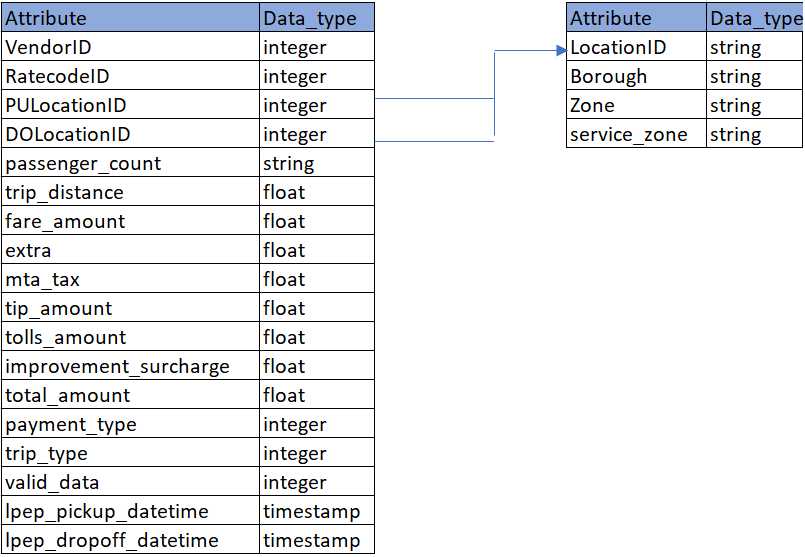

We create our schema by Spark as below.

In [40]:
green.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: float (nullable = true)
 |-- fare_amount: float (nullable = true)
 |-- extra: float (nullable = true)
 |-- mta_tax: float (nullable = true)
 |-- tip_amount: float (nullable = true)
 |-- tolls_amount: float (nullable = true)
 |-- improvement_surcharge: float (nullable = true)
 |-- total_amount: float (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- trip_type: integer (nullable = true)
 |-- valid_data: integer (nullable = false)
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- lpep_dropoff_datetime: timestamp (nullable = true)
 |-- count: long (nullable = true)
 |-- sum(total_amount): double (nullable = true)



In [41]:
location.printSchema()

root
 |-- LocationID: string (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



### Question 1: Top 10 popular pick up & drop off locations

#### Pick up

Through spark sql, we extract data of top 10 pick-up locations and counts of rides from them.

In [42]:
PU_location = sqlc.sql('''
SELECT green.PULocationID, location.Borough, location.Zone, count(1) AS PU_count
FROM green
JOIN location
ON green.PULocationID = location.LocationID
WHERE valid_data = 1
GROUP BY green.PULocationID, location.Borough, location.Zone
ORDER BY PU_count DESC
LIMIT 10
''')

In [43]:
import pandas as pd

In [44]:
#PySpark faster toPandas using mapPartitions
#https://gist.github.com/joshlk/871d58e01417478176e7
def _map_to_pandas(rdds):
    """ Needs to be here due to pickling issues """
    return [pd.DataFrame(list(rdds))]

def toPandas(df, n_partitions=None):
    """
    Returns the contents of `df` as a local `pandas.DataFrame` in a speedy fashion. The DataFrame is
    repartitioned if `n_partitions` is passed.
    :param df:              pyspark.sql.DataFrame
    :param n_partitions:    int or None
    :return:                pandas.DataFrame
    """
    if n_partitions is not None: df = df.repartition(n_partitions)
    df_pand = df.rdd.mapPartitions(_map_to_pandas).collect()
    df_pand = pd.concat(df_pand)
    df_pand.columns = df.columns
    return df_pand

In [45]:
PU_bar = toPandas(PU_location)

In [46]:
PU_bar

,PULocationID,Borough,Zone,PU_count
0,74,Manhattan,East Harlem North,59573
1,41,Manhattan,Central Harlem,54593
2,75,Manhattan,East Harlem South,52065
3,7,Queens,Astoria,50158
4,82,Queens,Elmhurst,42921
5,255,Brooklyn,Williamsburg (North Side),35897
6,166,Manhattan,Morningside Heights,35462
7,42,Manhattan,Central Harlem North,34317
8,181,Brooklyn,Park Slope,32795
9,97,Brooklyn,Fort Greene,29405


Draw bar chart

The pandas and matplotlib enable us to draw bar chart of top 10 pick-up location.

In [47]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

The bar charts indicates that there is little difference between contiguous locations, but rides from the first location East Harlem North is almost twice as many as ones from the last location Fort Greene.

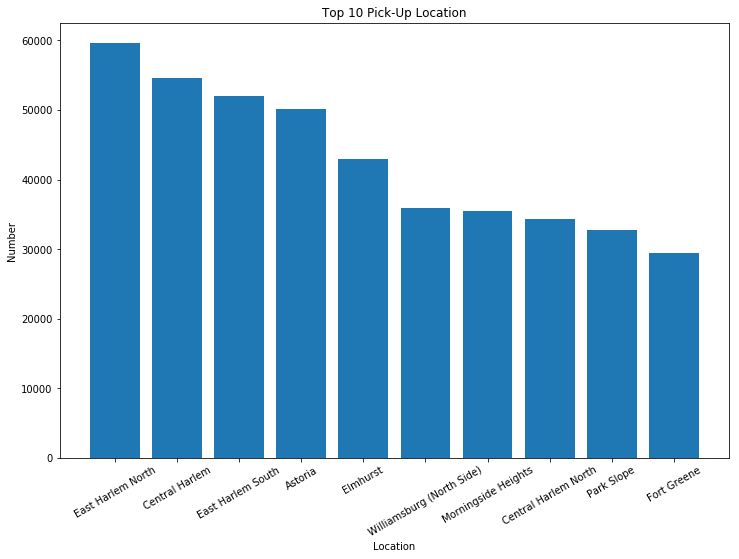

In [48]:
plt.clf()
fig = plt.figure(figsize=[12,8])
ax2=fig.add_subplot(1,1,1)
ax2.set(title = 'Top 10 Pick-Up Location', xlabel='Location', ylabel='Number')
_ = ax2.bar(np.arange(len(PU_bar)), height=np.array(PU_bar['PU_count']),width=0.8)
ax2.set_xticks(np.arange(len(PU_bar)))
ax2.set_xticklabels(PU_bar['Zone'])
for tick in ax2.get_xticklabels():
    tick.set_rotation(30)
plt.show()

#### Drop off

Through spark sql, we extract data of top 10 drop-off locations and counts of rides to them.

In [49]:
DO_location = sqlc.sql('''
SELECT green.DOLocationID, location.Borough, location.Zone, count(1) AS DO_count
FROM green
JOIN location
ON green.DOLocationID = location.LocationID
WHERE valid_data = 1
GROUP BY green.DOLocationID, location.Borough, location.Zone
ORDER BY DO_count DESC
LIMIT 10
''')

In [50]:
DO_bar = toPandas(DO_location)

In [51]:
DO_bar

,DOLocationID,Borough,Zone,DO_count
0,74,Manhattan,East Harlem North,32699
1,42,Manhattan,Central Harlem North,31720
2,7,Queens,Astoria,30697
3,41,Manhattan,Central Harlem,28581
4,129,Queens,Jackson Heights,27642
5,181,Brooklyn,Park Slope,24689
6,75,Manhattan,East Harlem South,20728
7,82,Queens,Elmhurst,19403
8,223,Queens,Steinway,17838
9,166,Manhattan,Morningside Heights,16970


Draw bar chart

Like the previous pick-up locations bar chart, there is little difference between contiguous locations, but rides to the first location East Harlem North is almost twice as many as ones to the last location Morningsides Heights.

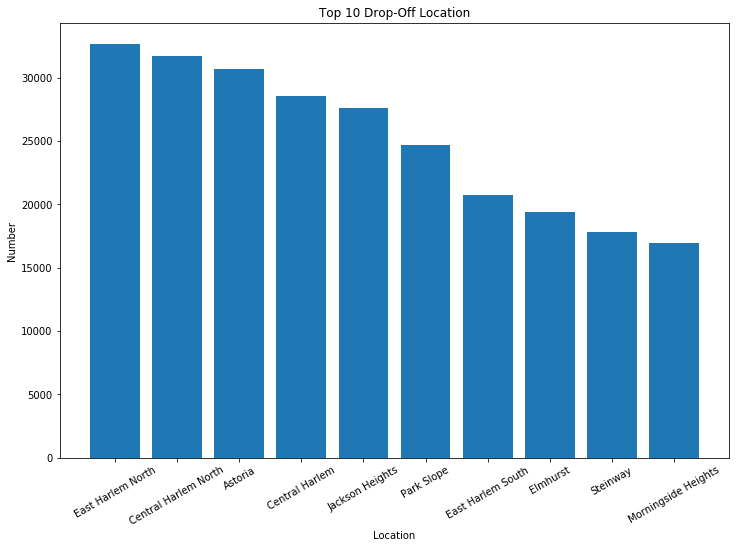

In [52]:
plt.clf()
fig = plt.figure(figsize=[12,8])
ax2=fig.add_subplot(1,1,1)
ax2.set(title = 'Top 10 Drop-Off Location', xlabel='Location', ylabel='Number')
_ = ax2.bar(np.arange(len(DO_bar)), height=np.array(DO_bar['DO_count']),width=0.8)
ax2.set_xticks(np.arange(len(DO_bar)))
ax2.set_xticklabels(DO_bar['Zone'])
for tick in ax2.get_xticklabels():
    tick.set_rotation(30)
plt.show()

### Question 2: The relationship of pick-up and drop-off locations - heat map

Based on previous results, we hope to explore the relationship between pick-up locations and drop-off locations in Heat Map

In [53]:
heat_map = sqlc.sql('''
SELECT PULocationID, DOLocationID, A.Borough AS PU_Borough, A.Zone AS PU_Zone, B.Borough AS DO_Borough, B.Zone AS DO_Zone, 
       count(1) AS route_count, round(avg(trip_distance), 2) AS trip, 
       round((avg(lpep_dropoff_datetime) - avg(lpep_pickup_datetime))/60, 2) AS time
FROM green
JOIN location AS A
ON green.PULocationID = A.LocationID
JOIN location AS B
ON green.DOLocationID = B.LocationID
WHERE valid_data = 1
AND PULocationID in
(
SELECT PULocationID
FROM
(
SELECT green.PULocationID, location.Borough, location.Zone, count(1) AS PU_count
FROM green
JOIN location
ON green.PULocationID = location.LocationID
WHERE valid_data = 1
GROUP BY green.PULocationID, location.Borough, location.Zone
ORDER BY PU_count DESC
LIMIT 10
))
AND DOLocationID in
(
SELECT DOLocationID
FROM
(
SELECT green.DOLocationID, location.Borough, location.Zone, count(1) AS DO_count
FROM green
JOIN location
ON green.DOLocationID = location.LocationID
WHERE valid_data = 1
GROUP BY green.DOLocationID, location.Borough, location.Zone
ORDER BY DO_count DESC
LIMIT 10
))
GROUP BY PULocationID, DOLocationID, PU_Borough, PU_Zone, DO_Borough, DO_Zone
ORDER BY route_count DESC
''')

In [54]:
heat_map = toPandas(heat_map)

In [55]:
heat_map2 = heat_map[['PU_Zone', 'DO_Zone', 'route_count']].pivot_table(index = 'PU_Zone', columns = 'DO_Zone',
                                                                        values = 'route_count')

In [56]:
heat_map2

DO_Zone,Astoria,Central Harlem,Central Harlem North,East Harlem North,East Harlem South,Elmhurst,Jackson Heights,Morningside Heights,Park Slope,Steinway
PU_Zone,,,,,,,,,,
Astoria,13360,48,47,90,122,966,2930,31,32,6571
Central Harlem,67,6443,9453,6950,2930,11,29,3391,14,58
Central Harlem North,23,5478,6887,3211,1161,4,10,1428,5,19
East Harlem North,154,6008,4698,6068,7364,25,47,3056,16,111
East Harlem South,128,3558,2246,9741,5358,56,85,1322,24,79
Elmhurst,1201,10,18,32,69,7065,7508,11,11,525
Fort Greene,43,10,11,9,15,24,26,13,1652,23
Morningside Heights,47,2813,2253,2661,899,5,16,3863,19,16
Park Slope,57,13,6,9,29,11,21,15,8192,29


The diagonal in heatmap is brighter and squares between different parts of Harlem is also brighter, which means that routes between the same zone or near zones are more frequent and people are willing to use taxi in short distance.

In [54]:
!pip install seaborn --user

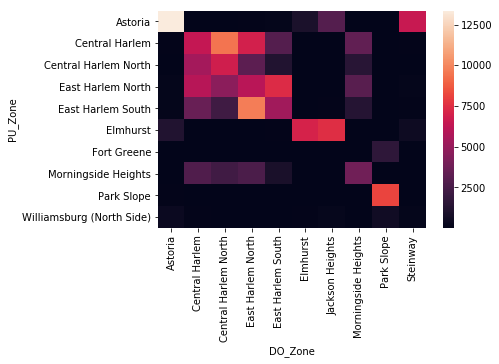

In [57]:
import seaborn as sns
sns.heatmap(heat_map2)

### Question 3: Top 10 common route 

As what we analyze before, citizens prefer to take taxi when their starting points are near to their destinations. 

In [58]:
sqlc.sql('''
SELECT PULocationID, DOLocationID, A.Borough AS PU_Borough, A.Zone AS PU_Zone, B.Borough AS DO_Borough, B.Zone AS DO_Zone, 
       count(1) AS route_count, round(avg(trip_distance), 2) AS trip, 
       round((avg(lpep_dropoff_datetime) - avg(lpep_pickup_datetime))/60, 2) AS time
FROM green
JOIN location AS A
ON green.PULocationID = A.LocationID
JOIN location AS B
ON green.DOLocationID = B.LocationID
WHERE valid_data = 1
GROUP BY PULocationID, DOLocationID, PU_Borough, PU_Zone, DO_Borough, DO_Zone
ORDER BY route_count DESC
LIMIT 10
''').show(10, False)

+------------+------------+----------+-----------------+----------+--------------------+-----------+----+-----+
|PULocationID|DOLocationID|PU_Borough|PU_Zone          |DO_Borough|DO_Zone             |route_count|trip|time |
+------------+------------+----------+-----------------+----------+--------------------+-----------+----+-----+
|7           |7           |Queens    |Astoria          |Queens    |Astoria             |13360      |0.85|13.79|
|75          |74          |Manhattan |East Harlem South|Manhattan |East Harlem North   |9741       |1.13|10.39|
|41          |42          |Manhattan |Central Harlem   |Manhattan |Central Harlem North|9453       |1.11|12.8 |
|181         |181         |Brooklyn  |Park Slope       |Brooklyn  |Park Slope          |8192       |0.92|11.49|
|129         |129         |Queens    |Jackson Heights  |Queens    |Jackson Heights     |7943       |1.05|13.28|
|82          |129         |Queens    |Elmhurst         |Queens    |Jackson Heights     |7508       |1.33

### Question 4: Distance & time hists

#### Distance

In [59]:
distance = sqlc.sql('''
SELECT trip_distance
FROM green
WHERE valid_data = 1
''')

The histogram below shows that distance of most rides is below 3 miles and the red dashed line indicates that average distance is about 2.5 miles, which verifies our expectation again.

In [60]:
distance = toPandas(distance)

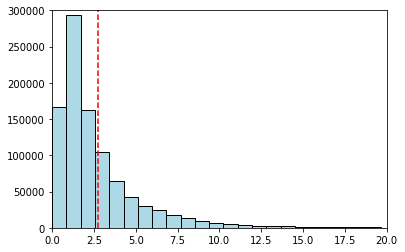

In [61]:
x = distance['trip_distance']
plt.hist(x, 200, color = 'lightblue', edgecolor='black')
plt.axis([0,20,0,300000])
plt.axvline(x.mean(),color = 'r', linestyle = 'dashed')
plt.show()

####  Time - hist

Due to the low distance of most trips, the time of most trips is lower than 20 minutes and average time of trips is about 20 minutes. We can conclude that most citizens are more willing to take taxi in trips of short distance.

In [62]:
trip_time = sqlc.sql('''
SELECT (cast(lpep_dropoff_datetime as double)  - cast(lpep_pickup_datetime as double)) /60 AS time_minutes
FROM green
WHERE valid_data = 1
''')

In [63]:
trip_time = toPandas(trip_time)

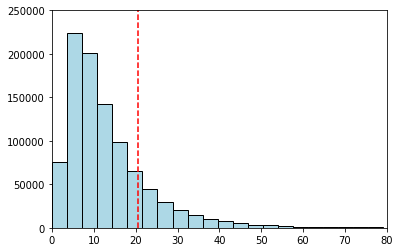

In [64]:
x = trip_time['time_minutes']
plt.hist(x, 400, color = 'lightblue', edgecolor='black')
plt.axis([0,80,0,250000])
plt.axvline(x.mean(),color = 'r', linestyle = 'dashed')
plt.show()

### Question 5: Total amount histogram

In [65]:
total_amount = sqlc.sql('''
SELECT total_amount/passenger_count AS amount_per_person
FROM green
WHERE valid_data = 1
AND passenger_count != 'NA'
''')

Because the distance is an important factor in total amount of fares, amounts of most trips are lower than 15 dollars. The average fare is about 13 dollars.

In [66]:
total_amount = toPandas(total_amount)

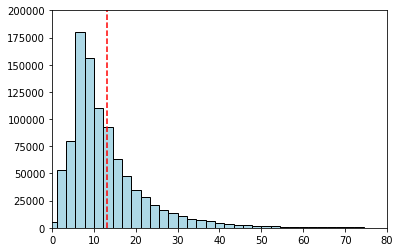

In [67]:
x = total_amount['amount_per_person']
plt.hist(x, 300, color = 'lightblue', edgecolor='black')
plt.axis([0,80,0,200000])
plt.axvline(x.mean(),color = 'r', linestyle = 'dashed')
plt.show()

### Question 6:  Check the relationship of speed and hours

In [68]:
rush_hour = sqlc.sql('''
SELECT ROUND(AVG(trip_distance / ((cast(lpep_dropoff_datetime as double) - cast(lpep_pickup_datetime as double))/3600)),2) AS speed,
       hour(lpep_pickup_datetime) AS PU_hour
FROM green
WHERE valid_data = 1
GROUP BY PU_hour
ORDER BY PU_hour
''')

The line chart shows that the average speed changes greatly with time and it becomes the lowest in rush hours. In 4 p.m., it is only about 10 miles per hour. So the rush hours have great influence in speed of traffic.

In [69]:
rush_hour =toPandas(rush_hour)

([<matplotlib.axis.XTick at 0x7f4b2dc03860>,
 <a list of 24 Text xticklabel objects>)

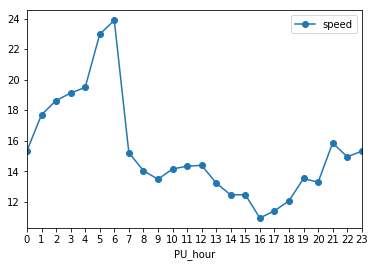

In [70]:
plt.clf()
rush_hour.plot(x = 'PU_hour', y = 'speed', marker = 'o')
plt.xticks(np.arange(len(rush_hour)))

### Part 4: Weather

In the bonus part, data of weather of New York in June is brought in, which helps us analyze the relationship between weather and taxi rides.

In [71]:
!wget https://russellxing.github.io/Guangyu_Xing/Weather_data_newyork_NY_USA_2017_06.csv

--2017-12-07 23:49:36--  https://russellxing.github.io/Guangyu_Xing/Weather_data_newyork_NY_USA_2017_06.csv
Resolving russellxing.github.io (russellxing.github.io)... 151.101.33.147
Connecting to russellxing.github.io (russellxing.github.io)|151.101.33.147|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2698 (2.6K) [text/csv]
Saving to: ‘Weather_data_newyork_NY_USA_2017_06.csv’

Weather_data_newyor 100%[===================>]   2.63K  --.-KB/s    in 0s      

2017-12-07 23:49:36 (61.2 MB/s) - ‘Weather_data_newyork_NY_USA_2017_06.csv’ saved [2698/2698]



There are datas of temperature, dew points, humidity, sea level, visibility, wind, precipation and events and we will use spark spl to load them.

In [72]:
!head Weather_data_newyork_NY_USA_2017_06.csv | csvlook

|-------------+-----------+----------+----------+----------+---------+---------+---------------+--------------+--------------+----------------+---------------+---------------+-----------------+----------------+----------------+----------+----------+-----------+--------------+---------|
|  Day        | Temp_high | Temp_avg | Temp_low | Dew_high | Dew_avg | Dew_low | Humidity_high | Humidity_avg | Humidity_low | Sea_Level_high | Sea_Level_avg | Sea_Level_low | Visibility_high | Visibility_avg | Visibility_low | Wind_avg | Wind_low | Wind_high | Precip. (in) | Events  |
|-------------+-----------+----------+----------+----------+---------+---------+---------------+--------------+--------------+----------------+---------------+---------------+-----------------+----------------+----------------+----------+----------+-----------+--------------+---------|
|  2017-06-01 | 79        | 69       | 59       | 61       | 52      | 44      | 93            | 63           | 32           | 29.97       

In [73]:
weather = sqlc.read.format("csv").option("header", "true").load("Weather_data_newyork_NY_USA_2017_06.csv")
weather.count()

30

In [74]:
weather.createOrReplaceTempView("weather")

In [75]:
sqlc.sql('''
SELECT *
FROM weather
''').show()

+----------+---------+--------+--------+--------+-------+-------+-------------+------------+------------+--------------+-------------+-------------+---------------+--------------+--------------+--------+--------+---------+------------+----------+
|       Day|Temp_high|Temp_avg|Temp_low|Dew_high|Dew_avg|Dew_low|Humidity_high|Humidity_avg|Humidity_low|Sea_Level_high|Sea_Level_avg|Sea_Level_low|Visibility_high|Visibility_avg|Visibility_low|Wind_avg|Wind_low|Wind_high|Precip. (in)|    Events|
+----------+---------+--------+--------+--------+-------+-------+-------------+------------+------------+--------------+-------------+-------------+---------------+--------------+--------------+--------+--------+---------+------------+----------+
|2017-06-01|       79|      69|      59|      61|     52|     44|           93|          63|          32|         29.97|        29.92|        29.87|             10|            10|             7|      13|       4|       22|           0|      Fine|
|2017-06-02|

In [76]:
Temp = sqlc.sql('''
SELECT weather.Day, weather.Temp_avg, count(1) AS rides_count
FROM green
JOIN weather
ON date(green.lpep_pickup_datetime) = weather.Day
WHERE valid_data = 1
GROUP BY weather.Day, weather.Temp_avg
ORDER BY weather.Temp_avg
''')

First of all, we aim to explore the relationship between temperature and count of rides. With the change of temperature, the count of rides also fluctuates greatly and there is no significant relationship between temperature and count of rides. 

In [77]:
Temp_pd = toPandas(Temp)

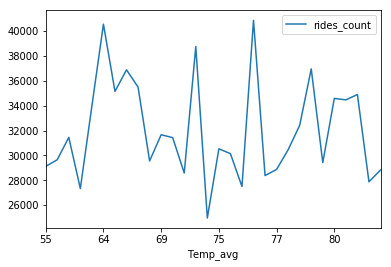

In [78]:
Temp_pd.plot(x = 'Temp_avg', y = 'rides_count')

In [79]:
Event = sqlc.sql('''
SELECT a.Events, avg(rides_count) as rides_count
FROM
(
SELECT weather.day, weather.Events, count(1) as rides_count
FROM green
JOIN weather
ON date(green.lpep_pickup_datetime) = weather.Day
WHERE valid_data = 1
GROUP BY weather.day, weather.Events
) a
GROUP BY a.Events
''')

In the rainy weather, the amount of rides does not increase significantly and is close to the one in fine weather. However, in the foggy and rainy weather, the amount of rides increase by about 10 percent, which indicates that the weather of fog plays an important role in increasing rides.

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

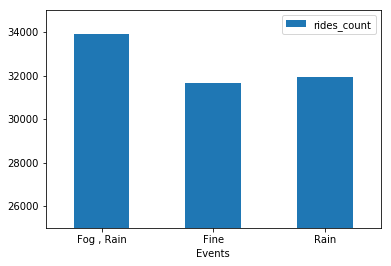

In [56]:
Event_pd = toPandas(Event)
Event_pd.plot(x = 'Events', y = 'rides_count',kind = 'bar')
plt.ylim(25000,35000)
plt.xticks(rotation = 0)

In [22]:
Precip = sqlc.sql('''
SELECT weather.Day, weather.`Precip. (in)` as precip, count(1) AS rides_count
FROM green
JOIN weather
ON date(green.lpep_pickup_datetime) = weather.Day
WHERE valid_data = 1
GROUP BY weather.Day, weather.`Precip. (in)`
ORDER BY precip
''')

Though the precipation changes, numbers of rides does not change greatly. Like the temperature, the precipation can not affect people's willing of traffic method greatly. 

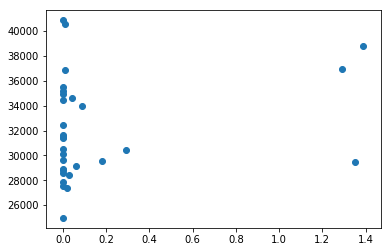

In [28]:
Precip_pd = toPandas(Precip)
plt.scatter(Precip_pd['precip'],Precip_pd['rides_count'])
plt.show()

In [65]:
Humidity = sqlc.sql('''
SELECT weather.Day, weather.Humidity_avg, count(1) AS rides_count
FROM green
JOIN weather
ON date(green.lpep_pickup_datetime) = weather.Day
WHERE valid_data = 1
GROUP BY weather.Day, weather.Humidity_avg
ORDER BY weather.Humidity_avg
''')

There is no great change in counts of rides when humidity changes, so humidity is not a vital factor in encouraging people to take taxi.

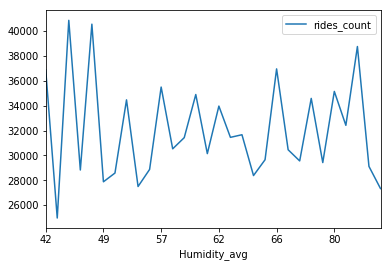

In [67]:
Humidity_pd = toPandas(Humidity)
Humidity_pd.plot(x = 'Humidity_avg', y = 'rides_count')

In [24]:
Wind = sqlc.sql('''
SELECT weather.Day, weather.Wind_avg, count(1) AS rides_count
FROM green
JOIN weather
ON date(green.lpep_pickup_datetime) = weather.Day
WHERE valid_data = 1
GROUP BY weather.Day, weather.Wind_avg
ORDER BY weather.Wind_avg
''')

Contrary to our expectations, higher speed of wind does not always lead to bigger number of rides which has great fluctuation. 

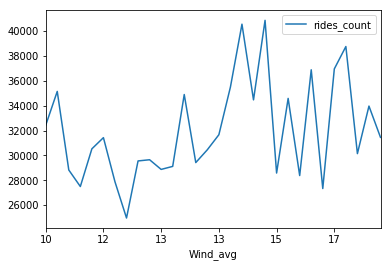

In [29]:
Wind_pd = toPandas(Wind)
Wind_pd.plot(x = 'Wind_avg', y = 'rides_count')